In [1]:
import os
import warnings
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score

import keras
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

warnings.filterwarnings(action="ignore")
%matplotlib inline

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [2]:
# Define file paths
healthy_dirs = [
    'test/NORMAL',
    'train/NORMAL',
    'val/NORMAL',
]

pneumonia_dir = [ 
    'test/PNEUMONIA',
    'train/PNEUMONIA',
    'val/PNEUMONIA',
]

In [3]:
filepaths = []
labels = []
dict_lists = [healthy_dirs, pneumonia_dir]
class_labels = ['Normal', 'Pneumonia']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
pneumonia_data = pd.concat([Fseries, Lseries], axis=1)
pneumonia_df = pd.DataFrame(pneumonia_data)
print(pneumonia_df.head())
print(pneumonia_df["labels"].value_counts())

                       filepaths  labels
0  test/NORMAL\IM-0001-0001.jpeg  Normal
1  test/NORMAL\IM-0003-0001.jpeg  Normal
2  test/NORMAL\IM-0005-0001.jpeg  Normal
3  test/NORMAL\IM-0006-0001.jpeg  Normal
4  test/NORMAL\IM-0007-0001.jpeg  Normal
labels
Pneumonia    4273
Normal       1583
Name: count, dtype: int64


In [4]:
pneumonia_df.shape

(5856, 2)

In [5]:
# Augmentation setup for normal images
normal_image_paths = pneumonia_df[pneumonia_df['labels'] == 'Normal']['filepaths'].tolist()
augmented_image_path = 'augmented/NORMAL/'  # Folder to save augmented images
os.makedirs(augmented_image_path, exist_ok=True)

# Define ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to save augmented images
def augment_image(image_path, save_dir, save_prefix, save_format='jpeg', n_copies=5):
    img = load_img(image_path)  # Load image
    x = img_to_array(img)  # Convert image to array
    x = x.reshape((1,) + x.shape)  # Reshape for ImageDataGenerator

    # Generate and save augmented images
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix=save_prefix, save_format=save_format):
        i += 1
        if i >= n_copies:
            break

In [6]:
# Apply augmentation to the normal images
#for img_path in normal_image_paths:
    #img_name = os.path.basename(img_path).split('.')[0]
    #augment_image(img_path, augmented_image_path, img_name)

In [7]:
# Print the number of augmented images generated
augmented_images = os.listdir(augmented_image_path)
print(f"Number of augmented images generated: {len(augmented_images)}")

Number of augmented images generated: 7912


In [8]:
# Load augmented images and add to the original dataset
augmented_filepaths = [os.path.join(augmented_image_path, img) for img in os.listdir(augmented_image_path)]
augmented_labels = ['Normal'] * len(augmented_filepaths)

# Create a new DataFrame for augmented images
augmented_Fseries = pd.Series(augmented_filepaths, name="filepaths")
augmented_Lseries = pd.Series(augmented_labels, name="labels")
augmented_data = pd.concat([augmented_Fseries, augmented_Lseries], axis=1)

# Append augmented data to the original dataset
updated_pneumonia_df = pd.concat([pneumonia_df, augmented_data], ignore_index=True)

# Shuffle the updated DataFrame to mix augmented and original data
updated_pneumonia_df = updated_pneumonia_df.sample(frac=1).reset_index(drop=True)

print(updated_pneumonia_df.head())
print(updated_pneumonia_df["labels"].value_counts())

                                           filepaths     labels
0         train/PNEUMONIA\person64_bacteria_318.jpeg  Pneumonia
1  augmented/NORMAL/NORMAL2-IM-0961-0001_0_9106.jpeg     Normal
2         train/PNEUMONIA\person1526_virus_2660.jpeg  Pneumonia
3         train/PNEUMONIA\person1258_virus_2138.jpeg  Pneumonia
4  augmented/NORMAL/NORMAL2-IM-0583-0001_0_4872.jpeg     Normal
labels
Normal       9495
Pneumonia    4273
Name: count, dtype: int64


In [9]:
# First split into train + validation (80%) and test set (20%)
train_val_df, test_df = train_test_split(updated_pneumonia_df, test_size=0.15, stratify=updated_pneumonia_df['labels'])

# Now split train + validation into training set (80% of 80%) and validation set (20% of 80%)
train_df, val_df = train_test_split(train_val_df, test_size=0.175, stratify=train_val_df['labels'])

print(train_df.shape)
#print(train_set.shape)
print(test_df.shape)
#print(test_set.shape)
print(val_df.shape)
#print(val_set.shape)

(9654, 2)
(2066, 2)
(2048, 2)


In [10]:
# Define ImageDataGenerator for training (with real-time augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Define ImageDataGenerator for validation (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Test set should not be shuffled
)

Found 9654 validated image filenames belonging to 2 classes.
Found 2048 validated image filenames belonging to 2 classes.
Found 2066 validated image filenames belonging to 2 classes.


In [11]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 9654 validated image filenames belonging to 2 classes.
Found 2066 validated image filenames belonging to 2 classes.
Found 2048 validated image filenames belonging to 2 classes.


In [12]:
classes=list(train_generator.class_indices.keys())
print (classes)


def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
    show_knee_images(train)

['Normal', 'Pneumonia']


In [ ]:
from tensorflow.keras.applications import ResNet50

def resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet = resnet_model()
resnet.summary()


94765736/94765736 [==============================] - 165s 2us/step
Model: "model"


In [ ]:
# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', # You can also use 'val_accuracy' depending on your goal
                               patience=6,        # Number of epochs to wait after no improvement
                               restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
                               verbose=1)

In [15]:
# Fit the model with early stopping
history = resnet.fit(train,
                    validation_data=val,
                    epochs=50,   # You can set a high number, early stopping will stop earlier if there's no improvement
                    callbacks=[early_stopping],  # Pass early stopping in the callbacks list
                    verbose=1)

2414/2414 [==============================] - 35172s 15s/step - loss: 0.4271 - accuracy: 0.8348 - val_loss: 16.9916 - val_accuracy: 0.7500
Epoch 2/50
2414/2414 [==============================] - 13223s 5s/step - loss: 0.3279 - accuracy: 0.8770 - val_loss: 0.2417 - val_accuracy: 0.9126
Epoch 3/50
2414/2414 [==============================] - 12083s 5s/step - loss: 0.2619 - accuracy: 0.9021 - val_loss: 0.8373 - val_accuracy: 0.8428
Epoch 4/50
2414/2414 [==============================] - 10381s 4s/step - loss: 0.2475 - accuracy: 0.9144 - val_loss: 0.1663 - val_accuracy: 0.9360
Epoch 5/50
2414/2414 [==============================] - 8160s 3s/step - loss: 0.1918 - accuracy: 0.9332 - val_loss: 0.5593 - val_accuracy: 0.8994
Epoch 6/50
2414/2414 [==============================] - 7785s 3s/step - loss: 0.1445 - accuracy: 0.9487 - val_loss: 0.1190 - val_accuracy: 0.9556
Epoch 7/50
2414/2414 [==============================] - 130548s 54s/step - loss: 0.1146 - accuracy: 0.9572 - val_loss: 1.6507 - v

In [17]:
resnet.evaluate(test, verbose=1)

517/517 [==============================] - 124s 239ms/step - loss: 0.0752 - accuracy: 0.9739


[0.07524869590997696, 0.9738625288009644]

In [18]:
resnet.save("pneumonia_Model.h5")
pred = resnet.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

517/517 [==============================] - 129s 249ms/step


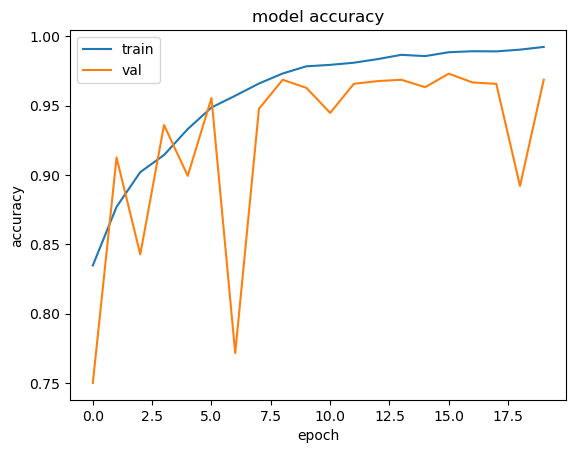

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

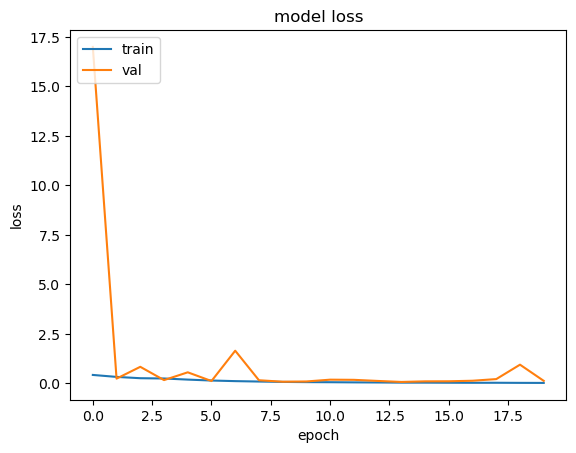

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
y_test = test_df.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      1425
   Pneumonia       0.96      0.96      0.96       641

    accuracy                           0.97      2066
   macro avg       0.97      0.97      0.97      2066
weighted avg       0.97      0.97      0.97      2066

Accuracy of the Model: 97.4%


In [22]:
cm = confusion_matrix(y_test, pred2)
print(cm)

[[1396   29]
 [  25  616]]


In [1]:
import matplotlib.pyplot as plt

# Set the range to only include epochs up to the early stopping point (epoch 16)
epochs = range(1, 15)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['accuracy'][:16], 'b-', marker='o', label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'][:16], 'r-', marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['loss'][:16], 'b-', marker='o', label='Train Loss')
plt.plot(epochs, history.history['val_loss'][:16], 'r-', marker='o', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

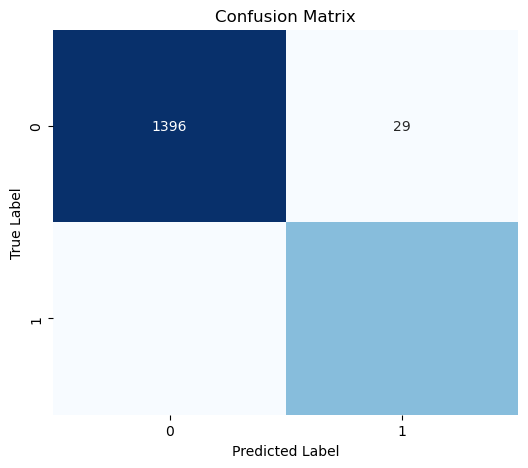

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix data
conf_matrix = np.array([[1396, 29], [25, 616]])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


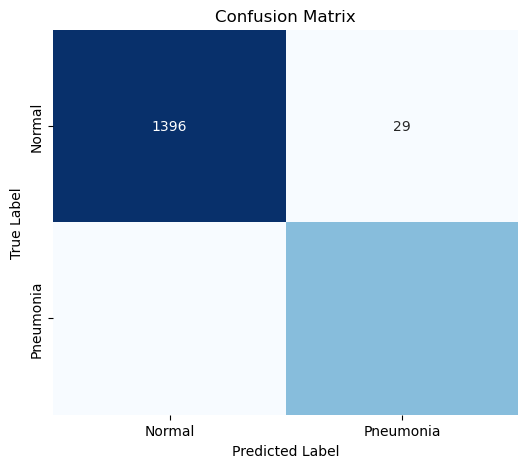

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix data
conf_matrix = np.array([[1396, 29], [25, 616]])

# Define labels
labels = ["Normal", "Pneumonia"]

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
